#### Import Statements

In [70]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import censusgeocode as cg
from census import Census
from us import states # US state abbreviations, and a few other things
import requests

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [72]:
%%R 

library(tidycensus)
library(tidyverse)
library(ggthemes)
# library(scales)

In [73]:
import pandas as pd
import os
import chardet  # Ensure you've installed chardet with pip install chardet


### Data Prep:

#### Library Data

In [74]:
df = pd.read_csv('data/1992_2021_AE.csv')
df

,LIBID,LIBNAME,ADDRESS,CITY,ZIP1,ZIP2,PHONE,POPU,CENTLIB,BRANLIB,...,GENATTEN,ONATTEN,OFFATTEN,VIRATTEN,TOTPRES,TOTVIEWS,PITUSRRPT,WIFISRPT,TOTINCM_CAP,TOTINCM_REG
0,40,ANCHOR POINT PUBLIC LIBRARY,BOX 129,ANCHOR POINT,99556,129.0,9072357345,1358.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,ANCHORAGE MUNICIPAL LIBRARIES,3600 DENALI,ANCHORAGE,99503,6093.0,9072612975,272262.0,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60,ANDERSON VILLAGE LIBRARY,BOX 3078,ANDERSON,99744,3078.0,9075822628,649.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70,ANIAK PUBLIC LIBRARY,BOX 270,ANIAK,99557,270.0,9076754435,529.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90,KUSKOKWIM CONSORTIUM LIBRARY,POUCH 1068,BETHEL,99559,1068.0,9075434516,4868.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274956,29,SUBLETTE COUNTY LIBRARY SYSTEM,155 S TYLER ST,PINEDALE,NaN,NaN,3073674114,NaN,1,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,CT,M,125.325046,215.534384
274957,30,TETON COUNTY LIBRARY,125 VIRGINIAN LANE,JACKSON,NaN,NaN,3077332164,NaN,1,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,M,CT,133.017830,204.079634
274958,31,UINTA COUNTY LIBRARY SYSTEM,701 MAIN ST,EVANSTON,NaN,NaN,3077830480,NaN,1,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,CT,CT,20.728117,38.746801
274959,32,WASHAKIE COUNTY LIBRARY,"801 BIG HORN AVE., SUITE 100",WORLAND,NaN,NaN,3073472231,NaN,1,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,CT,M,41.280677,48.552495


There are some years where the population of the legal service area is under the column "POPU" and some under the column "POPU_LSA". Here, I am merging the two columns together

In [75]:
df['POPU_LSA'] = df['POPU_LSA'].fillna(df['POPU'])

In [76]:
df['LOCGVT_PCT'] = df['LOCGVT'] / df['TOTINCM'] 
df['STGVT_PCT'] = df['STGVT'] / df['TOTINCM']
df['FEDGVT_PCT'] = df['FEDGVT'] / df['TOTINCM']
df['OTHINCM_PCT'] = df['OTHINCM'] / df['TOTINCM']

Filtering for Ohio

In [77]:
OH_df = df[df['STABR'] == 'OH']

#### Library Fund Tax Distribution Data

In [78]:
tax_data = pd.read_csv('data/taxDistribution.csv')
# guaranteed column is a string with a dollar sign and commas, so we need to remove those and convert the column to a float
tax_data['guaranteed'] = tax_data['guaranteed'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['excess'] = tax_data['excess'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['entitlement'] = tax_data['entitlement'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['entitlement_cap'] = tax_data['entitlement_cap'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['guaranteed_capita'] = tax_data['guaranteed_capita'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['excess_capita'] = tax_data['excess']/tax_data['population']
tax_data

,County,guaranteed,excess,entitlement,population,entitlement_cap,guaranteed_capita,prop_Tax,income_per_capita,excess_capita
0,CUYAHOGA,61404121.0,4798156.0,66202277.0,1265172,52.33,48.53,3421,156.968675,3.792493
1,HAMILTON,44978273.0,3514630.0,48492903.0,830639,58.38,54.15,3023,105.427656,4.231236
2,FRANKLIN,41432469.0,3237559.0,44670028.0,1344785,33.22,30.81,3708,92.165969,2.407492
3,MONTGOMERY,22906470.0,1789926.0,24696396.0,532531,46.38,43.01,2762,112.721380,3.361168
4,SUMMIT,20903237.0,1633392.0,22536629.0,551395,40.87,37.91,2739,83.957062,2.962290
...,...,...,...,...,...,...,...,...,...,...
83,HARRISON,657358.0,51366.0,708724.0,16234,43.66,40.49,1061,91.142540,3.164100
84,MONROE,552385.0,43164.0,595549.0,13385,44.49,41.27,977,43.654912,3.224804
85,MORGAN,523299.0,40890.0,564189.0,13802,40.88,37.91,1031,67.014491,2.962614
86,NOBLE,466961.0,36489.0,503450.0,7923,63.54,58.94,971,62.664900,4.605452


#### Census Data

In [79]:
%%R -o census_ohio

# Median real estate taxes paid for housing units with mortgages in 2021

options(tigris_use_cache = TRUE)

census_ohio <- get_acs(
  state = "OH",
  geography = "county",
  variables = "B25103_001E",
  geometry = FALSE,
  year = 2021
)

Getting data from the 2017-2021 5-year ACS
Using FIPS code '39' for state 'OH'


In [80]:
census_ohio['NAME'] = census_ohio['NAME'].str.replace(' County, Ohio', '').str.upper()
census_ohio['rank'] = census_ohio['estimate'].rank(ascending=False)
census_ohio.sort_values('rank', inplace=True)
census_ohio

,GEOID,NAME,variable,estimate,moe,rank
21,39041,DELAWARE,B25103_001,6125.0,96.0,1.0
28,39055,GEAUGA,B25103_001,4038.0,119.0,2.0
25,39049,FRANKLIN,B25103_001,3708.0,48.0,3.0
83,39165,WARREN,B25103_001,3657.0,68.0,4.0
29,39057,GREENE,B25103_001,3513.0,105.0,5.0
...,...,...,...,...,...,...
58,39115,MORGAN,B25103_001,1031.0,74.0,84.0
53,39105,MEIGS,B25103_001,1019.0,78.0,85.0
44,39087,LAWRENCE,B25103_001,1006.0,60.0,86.0
56,39111,MONROE,B25103_001,977.0,46.0,87.0


In [81]:
OH_subset_df = OH_df.groupby(['year', 'CNTY'])[['STGVT','TOTINCM', 'LOCGVT', 'POPU_LSA']].sum().reset_index()
OH_subset_df.sort_values(by=['year', 'POPU_LSA'], inplace=True)
OH_subset_df['STGVT_PER_CAPITA'] = OH_subset_df['STGVT'] / OH_subset_df['POPU_LSA']
OH_subset_df['LOCGVT_PER_CAPITA'] = OH_subset_df['LOCGVT'] / OH_subset_df['POPU_LSA']
OH_subset_df['TOTINCM_PER_CAPITA'] = OH_subset_df['TOTINCM'] / OH_subset_df['POPU_LSA']
OH_subset_df

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA
82,1992,VINTON,202733,288001,39152,11254.0,18.014306,3.478941,25.590990
61,1992,NOBLE,242247,251289,0,11645.0,20.802662,0.000000,21.579133
58,1992,MORGAN,251328,296364,7548,14183.0,17.720369,0.532186,20.895720
23,1992,FAIRFILED,390756,490101,0,14823.0,26.361465,0.000000,33.063550
56,1992,MONROE,282340,306047,0,15370.0,18.369551,0.000000,19.911971
...,...,...,...,...,...,...,...,...,...
2613,2021,MONTGOMERY,23759576,60027629,25338111,532531.0,44.616325,47.580537,112.721380
2633,2021,SUMMIT,21573328,46293504,21694449,551395.0,39.124998,39.344660,83.957062
2587,2021,HAMILTON,46653398,87572323,37362387,830639.0,56.165672,44.980295,105.427656
2574,2021,CUYAHOGA,63690984,198592372,120635915,1265172.0,50.341759,95.351395,156.968675


In [82]:
compMedInc = OH_subset_df.merge(census_ohio, left_on='CNTY', right_on='NAME').sort_values(by='STGVT_PER_CAPITA', ascending=False).drop(columns=['NAME', 'GEOID', 'variable','moe']).rename(columns={'estimate': 'PROPERTY_TAX'}).reset_index(drop=True)
compMedInc['STGVT_PER_CAPITA'] = compMedInc['STGVT_PER_CAPITA'].replace([np.inf, -np.inf], np.nan)
compMedInc.dropna(inplace=True)
compMedInc.sort_values(by='year', inplace=True)
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0


In [83]:
income_df = df[['year','STABR', 'LIBNAME', 'C_LEGBAS','LOCGVT','STGVT','FEDGVT','OTHINCM', 'TOTINCM', 'LOCGVT_PCT', 'STGVT_PCT', 'FEDGVT_PCT', 'OTHINCM_PCT', 'POPU_LSA']].reset_index().drop(columns='index')

columns_of_interest = ['LOCGVT','STGVT','FEDGVT','OTHINCM', 'TOTINCM', 'LOCGVT_PCT', 'STGVT_PCT', 'FEDGVT_PCT', 'OTHINCM_PCT', 'POPU_LSA']

# replacing missing data with NaN

income_df[columns_of_interest] = income_df[columns_of_interest].applymap(lambda x: np.nan if x < 0 else x)


income_df


,year,STABR,LIBNAME,C_LEGBAS,LOCGVT,STGVT,FEDGVT,OTHINCM,TOTINCM,LOCGVT_PCT,STGVT_PCT,FEDGVT_PCT,OTHINCM_PCT,POPU_LSA
0,1992,AK,ANCHOR POINT PUBLIC LIBRARY,NaN,0.0,6482.0,0.0,2721.0,9203.0,0.000000,0.704336,0.000000,0.295664,1358.0
1,1992,AK,ANCHORAGE MUNICIPAL LIBRARIES,NaN,6894038.0,76466.0,75746.0,327940.0,7374190.0,0.934887,0.010369,0.010272,0.044471,272262.0
2,1992,AK,ANDERSON VILLAGE LIBRARY,NaN,3500.0,8705.0,0.0,2682.0,14887.0,0.235104,0.584738,0.000000,0.180157,649.0
3,1992,AK,ANIAK PUBLIC LIBRARY,NaN,8926.0,8705.0,0.0,0.0,17631.0,0.506267,0.493733,0.000000,0.000000,529.0
4,1992,AK,KUSKOKWIM CONSORTIUM LIBRARY,NaN,78362.0,13764.0,3500.0,167923.0,263549.0,0.297334,0.052226,0.013280,0.637160,4868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274956,2021,WY,SUBLETTE COUNTY LIBRARY SYSTEM,CO,1084037.0,0.0,0.0,9800.0,1093837.0,0.991041,0.000000,0.000000,0.008959,8728.0
274957,2021,WY,TETON COUNTY LIBRARY,CO,2822034.0,0.0,0.0,281405.0,3103439.0,0.909325,0.000000,0.000000,0.090675,23331.0
274958,2021,WY,UINTA COUNTY LIBRARY SYSTEM,CO,410721.0,0.0,0.0,13169.0,423890.0,0.968933,0.000000,0.000000,0.031067,20450.0
274959,2021,WY,WASHAKIE COUNTY LIBRARY,CO,308584.0,0.0,0.0,8658.0,317242.0,0.972709,0.000000,0.000000,0.027291,7685.0


#### GDP/Economic Data

In [84]:
ohio_gdp = pd.read_csv('data/ohio-gdp.csv')
ohio_gdp

,year,PCT_GDP_US,PCT_GDP_OHIO,PCT_STGVT,PCT_LOCGVT,PCT_TOTINCM
0,1993,2.75,4.120187,5.8482,14.923,7.0702
1,1994,4.03,5.600573,4.3543,10.728,7.4914
2,1995,2.68,4.814601,7.1132,18.105,8.7553
3,1996,3.77,4.667548,7.8619,11.774,8.7065
4,1997,4.45,5.823223,9.0592,-1.145,8.4980
5,1998,4.48,5.773373,13.5830,15.450,15.8919
6,1999,4.79,2.986887,6.7283,2.866,2.2455
7,2000,4.08,5.336736,8.6020,6.330,9.1602
8,2001,0.95,2.901926,0.8541,0.009,0.2956
9,2002,1.70,1.576547,-8.0209,1.469,-5.4262


In [85]:
personal_income = pd.read_csv('data/personal-income.csv')
personal_income = pd.melt(personal_income, id_vars=['County'], var_name='year', value_name='personal_income')

personal_income

,County,year,personal_income
0,ADAMS,1992,0.127775
1,ALLEN,1992,0.851547
2,ASHLAND,1992,0.368489
3,ASHTABULA,1992,0.614261
4,ATHENS,1992,0.374086
...,...,...,...
2635,WASHINGTON,2021,0.395329
2636,WAYNE,2021,0.829057
2637,WILLIAMS,2021,0.195575
2638,WOOD,2021,1.053471


### Analysis

##### Ohio's state government has consistently allocated more funds for its libraries than any other state.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


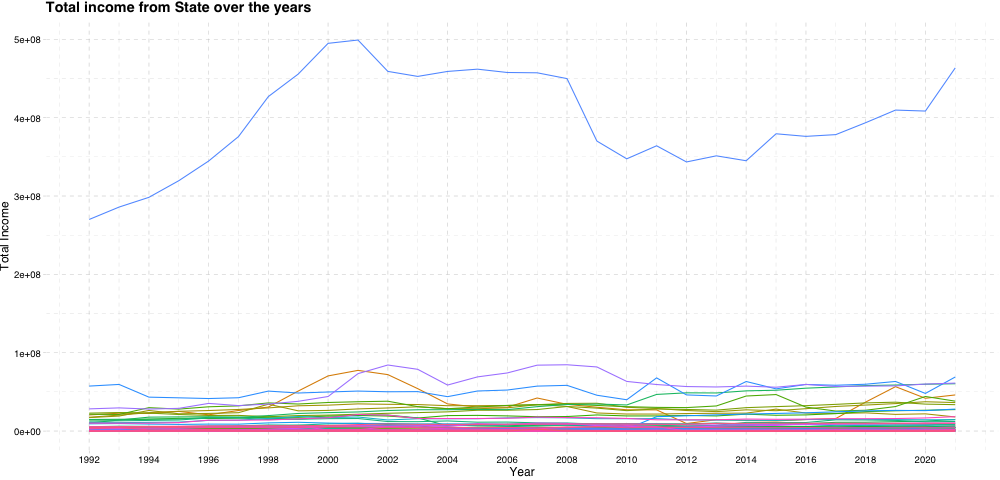

In [86]:
%%R -i income_df -w 1000 
# remove OH from the dataset
# income_df <- income_df %>% filter(STABR == 'OH')

income_df %>%
    group_by(year, STABR) %>%
    summarise(total_income = sum(STGVT, na.rm = TRUE)) %>%
    ggplot(aes(x = year, y = total_income, color = STABR)) +
    geom_line() +
    scale_x_continuous(breaks = seq(min(income_df$year), max(income_df$year), by = 2)) + # Adjusted to dynamically cover the range of years in the dataset
    labs(title = 'Total income from State over the years',
         x = 'Year',
         y = 'Total Income'
        ) +
    # geom_text(aes(label = STABR), nudge_x = 0.5, nudge_y = 0.5, check_overlap = TRUE) +
    theme_pander() + 
    # remove legend
    theme(legend.position = 'none')

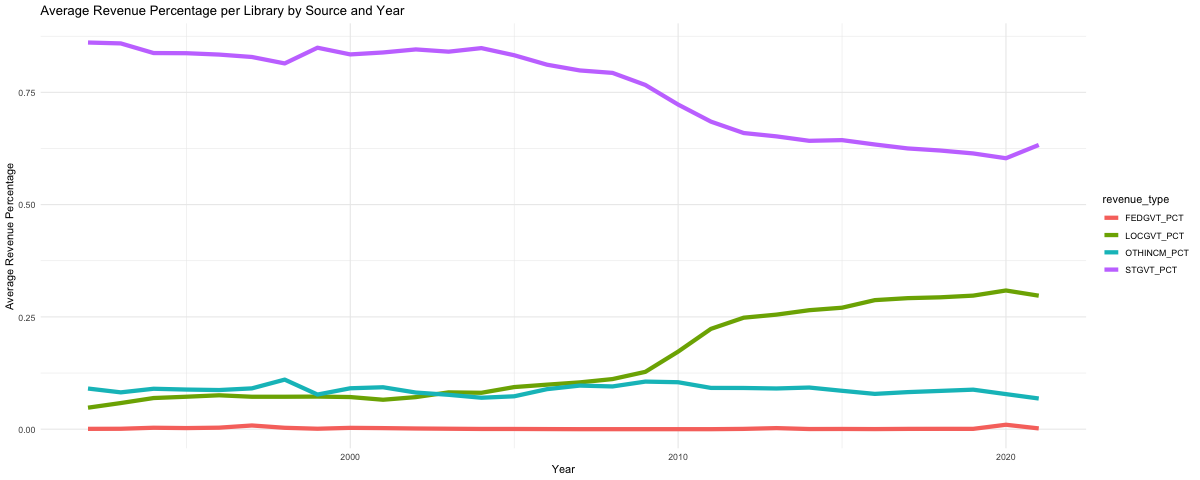

In [87]:
%%R -i OH_df -w 1200


OH_df <- OH_df %>%
  group_by(year) %>%
  summarise(
    LIBRARY_COUNT = n(), 
    LOCGVT_PCT = mean(LOCGVT_PCT, na.rm = TRUE), 
    STGVT_PCT = mean(STGVT_PCT, na.rm = TRUE), 
    FEDGVT_PCT = mean(FEDGVT_PCT, na.rm = TRUE),
    OTHINCM_PCT = mean(OTHINCM / TOTINCM, na.rm = TRUE)  # Assuming you want this as well
  )

income_long <- pivot_longer(OH_df, 
                            cols = c("LOCGVT_PCT", "STGVT_PCT", "FEDGVT_PCT", "OTHINCM_PCT"), 
                            names_to = "revenue_type", 
                            values_to = "percentage")

ggplot(income_long, aes(x = year, y = percentage, color = revenue_type)) +
  geom_line(size = 2) +
  labs(title = "Average Revenue Percentage per Library by Source and Year", 
       x = "Year", 
       y = "Average Revenue Percentage") +
  theme_minimal() 

  # ggsave('average_revenue_percentage_ohio.svg')

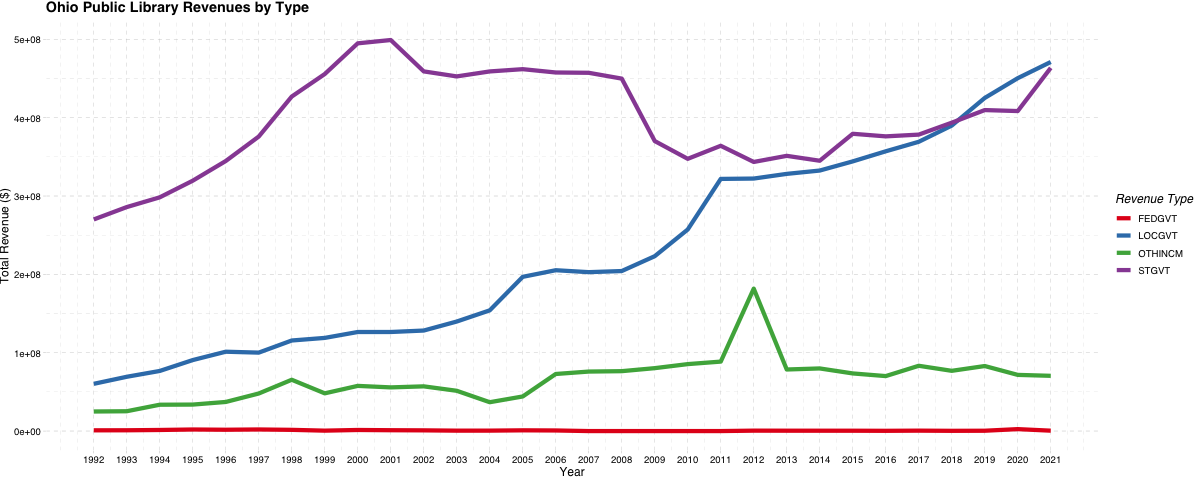

In [88]:
%%R -i OH_df -w 1200

OH_df <- OH_df %>%
  group_by(year) %>%
  summarise(
    LIBRARY_COUNT = n(), 
    LOCGVT = sum(LOCGVT, na.rm = TRUE), 
    STGVT = sum(STGVT, na.rm = TRUE), 
    FEDGVT = sum(FEDGVT, na.rm = TRUE),
    OTHINCM = sum(OTHINCM, na.rm = TRUE)
  )

income_long <- pivot_longer(OH_df, 
                            cols = c("LOCGVT", "STGVT", "FEDGVT", "OTHINCM"), 
                            names_to = "revenue_type", 
                            values_to = "total_income")

ggplot(income_long, aes(x = year, y = total_income, color = revenue_type)) +
  geom_line(size = 2) +
    labs(title = "Ohio Public Library Revenues by Type",
         x = "Year",
         y = "Total Revenue ($)",
         color = "Revenue Type") +
      #  i want to see tick marks for every year
  scale_x_continuous(breaks = seq(min(OH_df$year), max(OH_df$year), by = 1)) +
  theme_pander() +
  scale_color_brewer(palette = "Set1")  


##### Does the state distribute its funding evenly across all the counties? 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


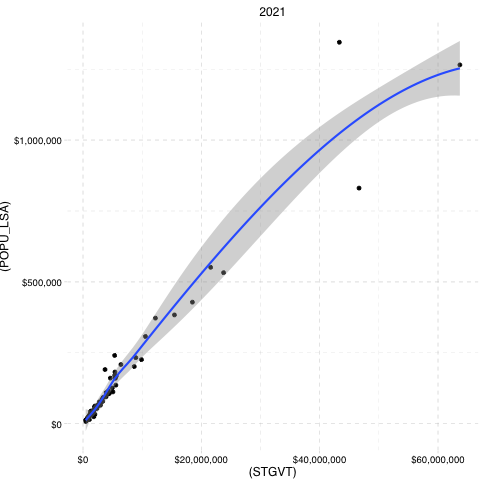

In [89]:
%%R -i compMedInc 

compMedInc <- compMedInc %>% filter(year == 2021)

ggplot(compMedInc, aes(x = (STGVT), y = (POPU_LSA))) +
    geom_point() +
    # geom_text(aes(label = CNTY), check_overlap = TRUE, vjust = 1, hjust = 1) +
    theme_minimal() +
    geom_smooth() +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_x_continuous(labels = scales::dollar) +
    scale_y_continuous(labels = scales::dollar) +
    facet_wrap(~year, ncol = 4) +
    theme(legend.position = "none") + 
    theme_pander()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


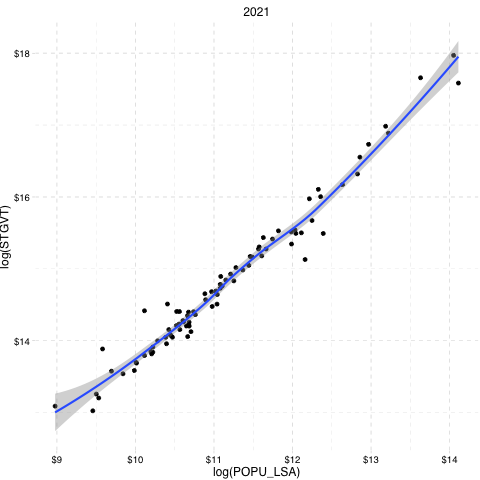

In [90]:
%%R -i compMedInc 

compMedInc <- compMedInc %>% filter(year == 2021)

ggplot(compMedInc, aes(y = log(STGVT), x = log(POPU_LSA))) +
    geom_point() +
    # geom_text(aes(label = CNTY), check_overlap = TRUE, vjust = 1, hjust = 1) +
    theme_minimal() +
    geom_smooth() +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_x_continuous(labels = scales::dollar) +
    scale_y_continuous(labels = scales::dollar) +
    facet_wrap(~year, ncol = 4) +
    # geom_text(aes(label = CNTY), check_overlap = FALSE, vjust = 1, hjust = 1) +
    theme(legend.position = "none") + 
    theme_pander()

In [91]:
%%R -i compMedInc

model <- lm(log(STGVT) ~ log(POPU_LSA), data = compMedInc)
summary(model)


Call:
lm(formula = log(STGVT) ~ log(POPU_LSA), data = compMedInc)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90527 -0.13379  0.02399  0.17164  0.93232 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.018665   0.051556   58.55   <2e-16 ***
log(POPU_LSA) 1.036947   0.004606  225.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2332 on 2638 degrees of freedom
Multiple R-squared:  0.9505,	Adjusted R-squared:  0.9505 
F-statistic: 5.069e+04 on 1 and 2638 DF,  p-value: < 2.2e-16



In [92]:
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0


In [93]:
tax_data

,County,guaranteed,excess,entitlement,population,entitlement_cap,guaranteed_capita,prop_Tax,income_per_capita,excess_capita
0,CUYAHOGA,61404121.0,4798156.0,66202277.0,1265172,52.33,48.53,3421,156.968675,3.792493
1,HAMILTON,44978273.0,3514630.0,48492903.0,830639,58.38,54.15,3023,105.427656,4.231236
2,FRANKLIN,41432469.0,3237559.0,44670028.0,1344785,33.22,30.81,3708,92.165969,2.407492
3,MONTGOMERY,22906470.0,1789926.0,24696396.0,532531,46.38,43.01,2762,112.721380,3.361168
4,SUMMIT,20903237.0,1633392.0,22536629.0,551395,40.87,37.91,2739,83.957062,2.962290
...,...,...,...,...,...,...,...,...,...,...
83,HARRISON,657358.0,51366.0,708724.0,16234,43.66,40.49,1061,91.142540,3.164100
84,MONROE,552385.0,43164.0,595549.0,13385,44.49,41.27,977,43.654912,3.224804
85,MORGAN,523299.0,40890.0,564189.0,13802,40.88,37.91,1031,67.014491,2.962614
86,NOBLE,466961.0,36489.0,503450.0,7923,63.54,58.94,971,62.664900,4.605452


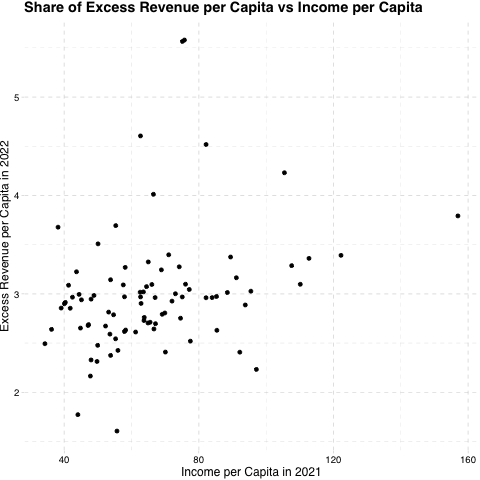

In [94]:
%%R -i tax_data

ggplot(tax_data, aes(x = income_per_capita, y = excess_capita)) +
    geom_point() +
    # geom_smooth() +
    labs(title = "Share of Excess Revenue per Capita vs Income per Capita",
         x = "Income per Capita in 2021",
         y = "Excess Revenue per Capita in 2022") +
    theme_pander() +
    theme(legend.position = 'none')

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


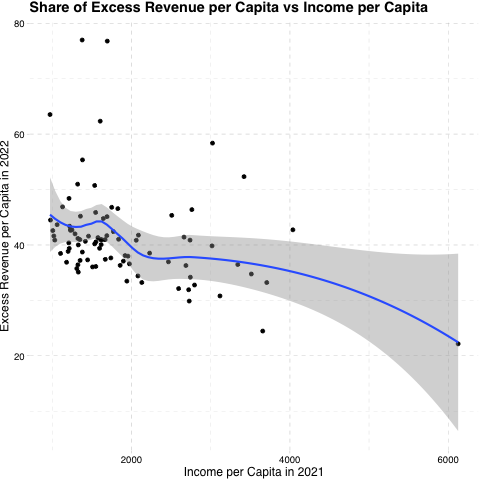

In [95]:
%%R -i tax_data

ggplot(tax_data, aes(x = prop_Tax, y = entitlement_cap)) +
    geom_point() +
    geom_smooth() +
    labs(title = "Share of Excess Revenue per Capita vs Income per Capita",
         x = "Income per Capita in 2021",
         y = "Excess Revenue per Capita in 2022") +
    theme_pander() +
    theme(legend.position = 'none')

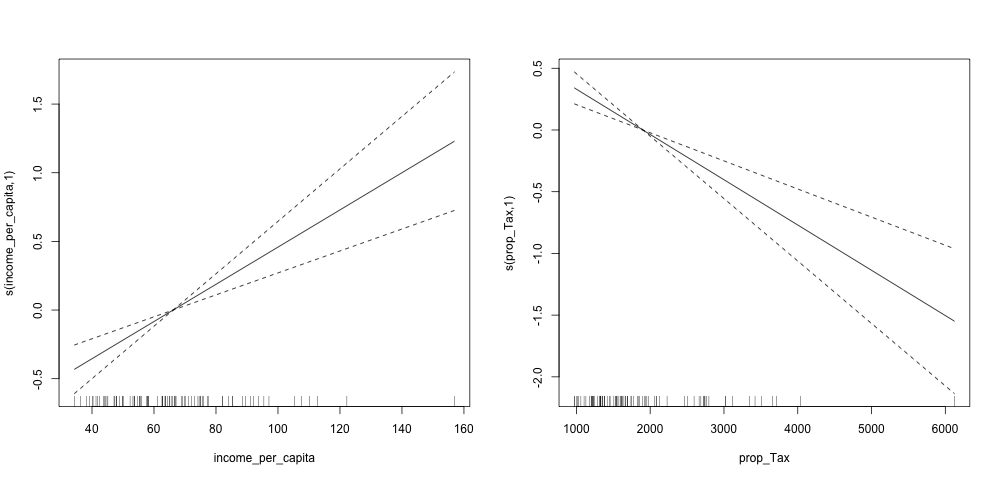

In [96]:
%%R -i tax_data -w 1000

library(mgcv)

model <- gam(excess_capita ~ s(income_per_capita) + s(prop_Tax), data = tax_data)
summary(model)

# plot the model
plot(model, pages = 1, scale = 0)

##### Is there a relationship between Ohio's library funding and the overall US/Ohio economy? Is it true that “when Ohio does well, the libraries do well?”

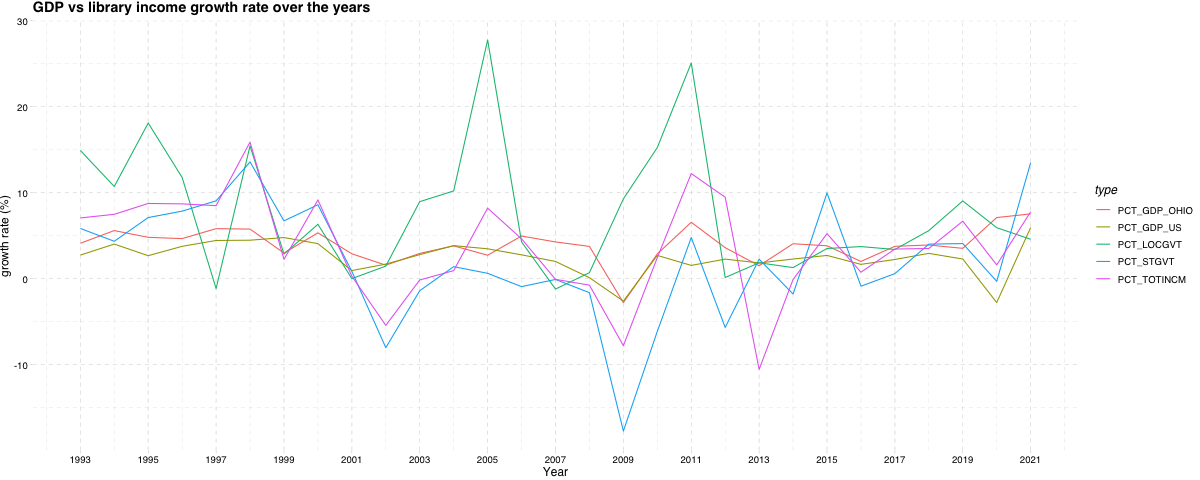

In [97]:
%%R -i ohio_gdp -w 1200

ohio_gdp %>% pivot_longer(cols = -c('year'), names_to = 'type', values_to = 'pct') %>%
    ggplot(aes(x = year, y = pct, color = type)) +
    geom_line() +
    theme_pander() + 
    labs(title = 'GDP vs library income growth rate over the years',
         x = 'Year',
         y = 'growth rate (%)'
        ) +
    scale_x_continuous(breaks = seq(min(ohio_gdp$year), max(ohio_gdp$year), by = 2))  # Adjusted to dynamically cover the range of years in the dataset


In [98]:
%%R -i ohio_gdp -w 1200

model = lm(PCT_TOTINCM ~ PCT_GDP_US+ PCT_GDP_OHIO + PCT_LOCGVT, data = ohio_gdp)
# model = lm(PCT_TOTINCM ~ PCT_GDP_US + PCT_GDP_OHIO, data = ohio_gdp)

summary(model)


Call:
lm(formula = PCT_TOTINCM ~ PCT_GDP_US + PCT_GDP_OHIO + PCT_LOCGVT, 
    data = ohio_gdp)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2882 -2.1122 -0.0957  1.8024  8.5440 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.72021    1.53857  -4.368 0.000192 ***
PCT_GDP_US    0.81160    0.37586   2.159 0.040617 *  
PCT_GDP_OHIO  1.59743    0.35706   4.474 0.000146 ***
PCT_LOCGVT    0.29672    0.08663   3.425 0.002129 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.396 on 25 degrees of freedom
Multiple R-squared:  0.6966,	Adjusted R-squared:  0.6602 
F-statistic: 19.13 on 3 and 25 DF,  p-value: 1.168e-06



In [99]:
%%R -i ohio_gdp -w 1200

model = lm(PCT_STGVT ~ PCT_GDP_US+ PCT_GDP_OHIO , data = ohio_gdp)
# model = lm(PCT_TOTINCM ~ PCT_GDP_US + PCT_GDP_OHIO, data = ohio_gdp)

summary(model)


Call:
lm(formula = PCT_STGVT ~ PCT_GDP_US + PCT_GDP_OHIO, data = ohio_gdp)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8877 -2.2956  0.3849  2.4799  7.6553 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -8.9111     1.5901  -5.604 6.88e-06 ***
PCT_GDP_US     1.6447     0.4092   4.019 0.000445 ***
PCT_GDP_OHIO   1.7682     0.3888   4.548 0.000111 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.707 on 26 degrees of freedom
Multiple R-squared:  0.7089,	Adjusted R-squared:  0.6865 
F-statistic: 31.66 on 2 and 26 DF,  p-value: 1.077e-07



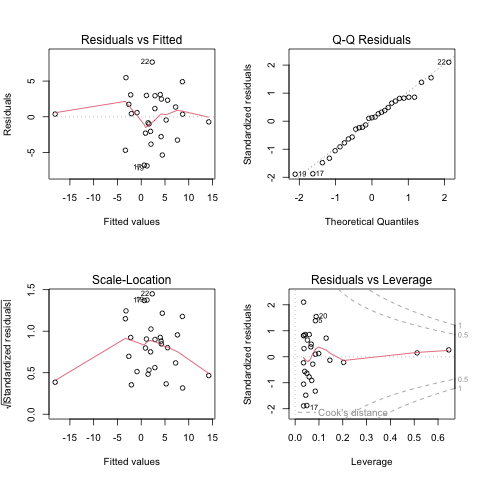

In [100]:
%%R -i ohio_gdp

par(mfrow = c(2, 2))
plot(model)

##### Libraries with lower reliance on state funding and a higher reliance on local levies have higher income per capita

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


In addition: Warning message:
The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 


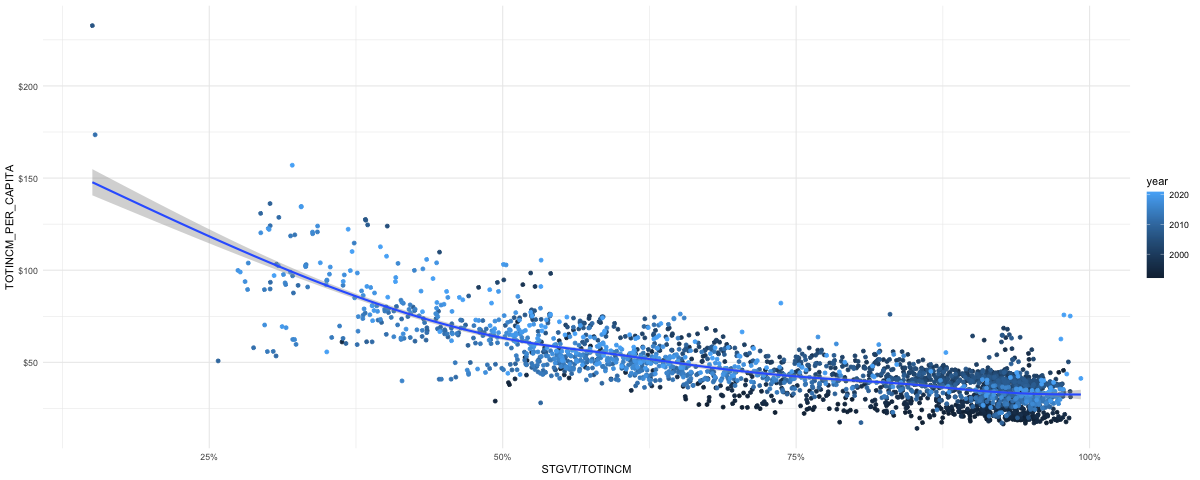

In [101]:
%%R -i compMedInc -w 1200 

plot <- ggplot(compMedInc, aes(x = STGVT/TOTINCM, y = TOTINCM_PER_CAPITA, color = year)) +
            geom_point() +
            # geom_text(aes(label = CNTY), check_overlap = TRUE, vjust = 1, hjust = 1) +
            theme_minimal() +
            geom_smooth( ) +
            theme(plot.title = element_text(hjust = 0.5)) +
            scale_x_continuous(labels = scales::percent) +
            scale_y_continuous(labels = scales::dollar) +
            # facet_wrap(~year, ncol = 1) +
            theme(legend.position = "none") + 
            theme_minimal()

print(plot)

In [102]:
compMedInc['LOCPCT'] = compMedInc['LOCGVT'] / compMedInc['TOTINCM']
compMedInc['STGPCT'] = compMedInc['STGVT'] / compMedInc['TOTINCM']


Family: gaussian 
Link function: identity 

Formula:
TOTINCM_PER_CAPITA ~ s(LOCPCT) + s(year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  44.9830     0.1837   244.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(LOCPCT) 7.996  8.730 517.8  <2e-16 ***
s(year)   8.840  8.992 145.2  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.735   Deviance explained = 73.7%
GCV = 89.712  Scale est. = 89.106    n = 2640


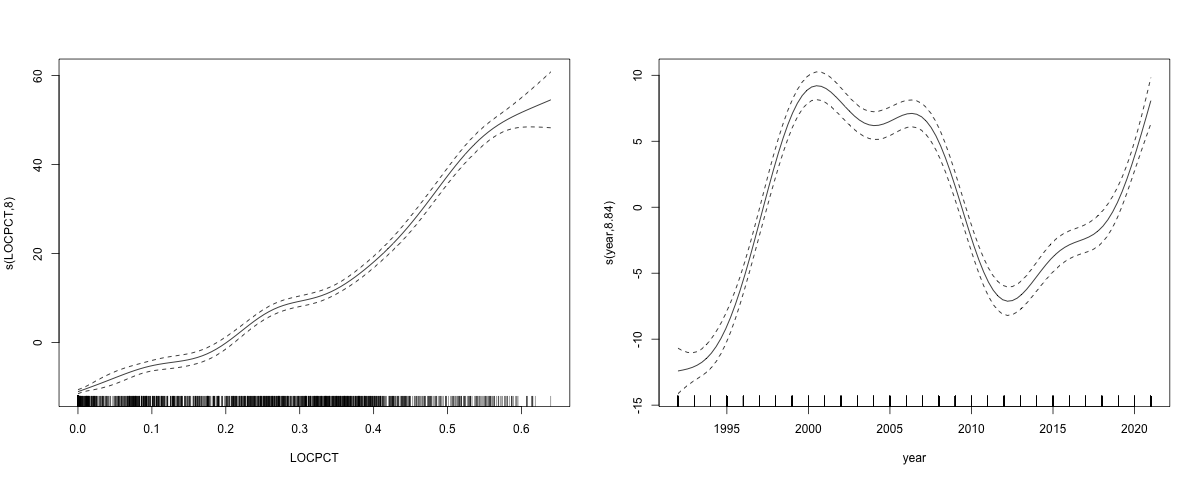

In [103]:
%%R -i compMedInc -w 1200 
library(mgcv)
library(dplyr)



gam_model <- gam(TOTINCM_PER_CAPITA ~ s(LOCPCT) + s(year), data = compMedInc)
print(summary(gam_model))

plot(gam_model, pages = 1, scale = 0)

NULL
$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.14753, p-value < 2.2e-16
alternative hypothesis: two-sided


$dispersion

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.99235, p-value = 0.792
alternative hypothesis: two.sided


$outliers

	DHARMa outlier test based on exact binomial test with approximate
	expectations

data:  simulationOutput
outliers at both margin(s) = 57, observations = 2640, p-value =
5.653e-11
alternative hypothesis: true probability of success is not equal to 0.007968127
95 percent confidence interval:
 0.01639276 0.02788398
sample estimates:
frequency of outliers (expected: 0.00796812749003984 ) 
                                            0.02159091 


$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.14753, p-value < 2.2e-16
alternative hypothesis: two-sided


$dispersi

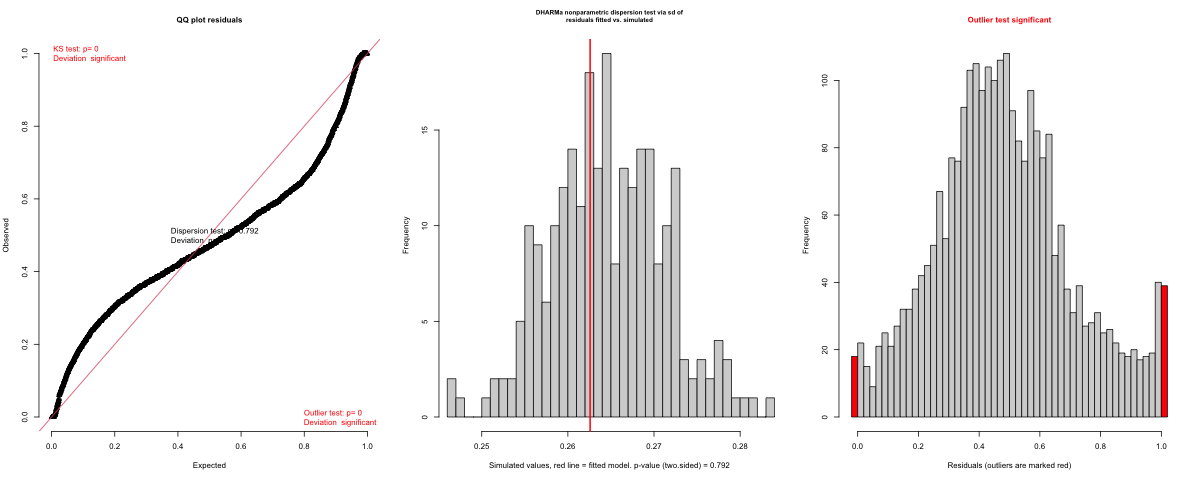

In [104]:
%%R -i compMedInc -w 1200 
library(mgcv)
library(dplyr)

library(DHARMa)

simulationOutput <- simulateResiduals(fittedModel = gam_model)
print(plot(simulationOutput))
testResiduals(simulationOutput)


##### Is % Local Gvt Funding Higher in Areas with Higher Property Tax

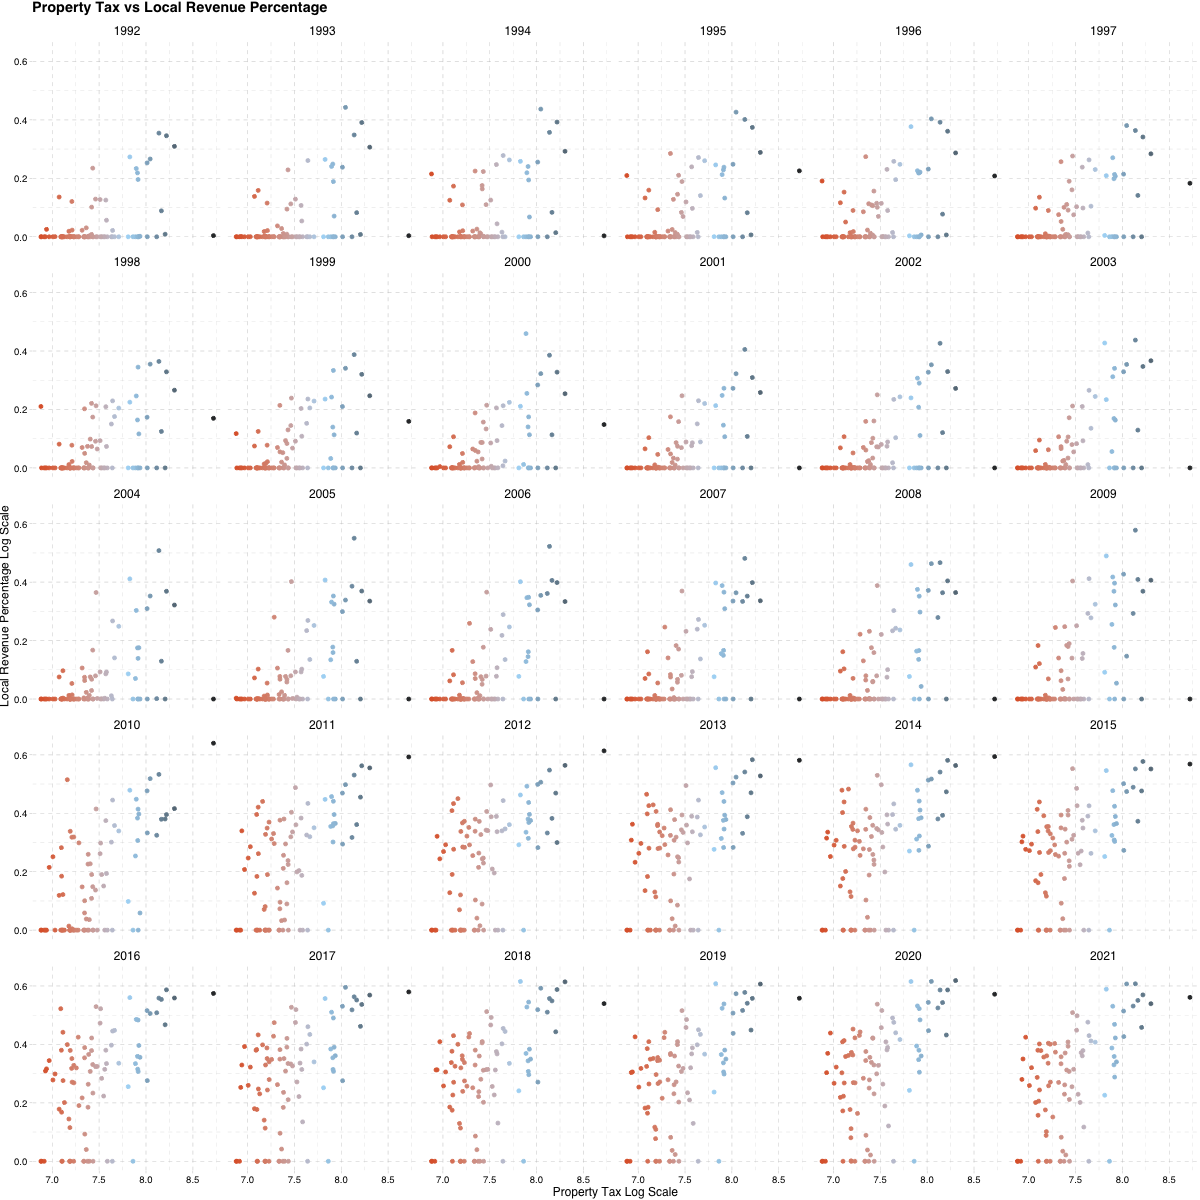

In [139]:
%%R -i compMedInc -w 1200 -h 1200

ggplot(compMedInc, aes(x = log(PROPERTY_TAX), y = LOCPCT, color = log(PROPERTY_TAX))) +
    geom_point() +
    # geom_smooth() +
    labs(title = "Property Tax vs Local Revenue Percentage",
         x = "Property Tax Log Scale",
         y = "Local Revenue Percentage Log Scale") +
    theme_pander() +
    facet_wrap(~year) +
    theme(legend.position = 'none')+
#     color palette with three colors
     scale_color_gradientn(colors = c("#DE6437", "#AEDAF8", "#303335"))


Family: gaussian 
Link function: identity 

Formula:
LOCPCT ~ s(PROPERTY_TAX) + s(year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.149619   0.002322   64.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df     F p-value    
s(PROPERTY_TAX) 8.195  8.809 126.4  <2e-16 ***
s(year)         8.271  8.854 211.1  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.53   Deviance explained = 53.3%
GCV = 0.014326  Scale est. = 0.014231  n = 2640


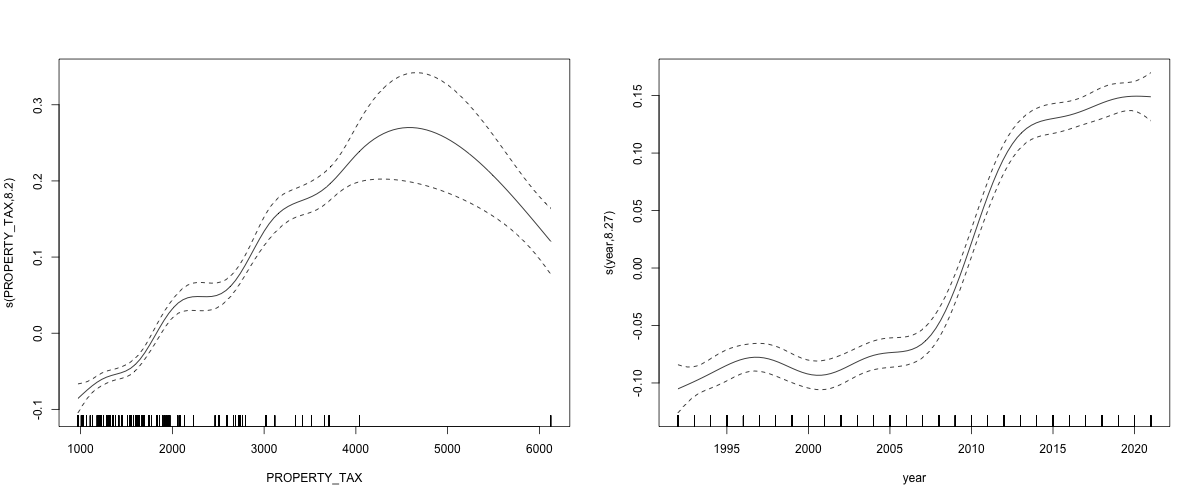

In [105]:
%%R -i compMedInc -h 500 -w 1200
library(mgcv)
library(dplyr)

# compMedInc$PROPERTY_TAX_log <- log(compMedInc$PROPERTY_TAX + 1)
gam_model_log <- gam(LOCPCT ~ s(PROPERTY_TAX) + s(year) , data = compMedInc)

# gam_model <- gam(LOCGVT_PER_CAPITA ~ s(PROPERTY_TAX) + s(year) + s(STRATIO), data = compMedInc)

print(summary(gam_model_log))


par(mfrow=c(3, 3)) 
plot(gam_model_log, pages=1, all.terms=TRUE, se=TRUE, scale=0)

par(mfrow=c(1,1))


NULL
$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.07747, p-value = 3.464e-14
alternative hypothesis: two-sided


$dispersion

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.99249, p-value = 0.8
alternative hypothesis: two.sided


$outliers

	DHARMa outlier test based on exact binomial test with approximate
	expectations

data:  simulationOutput
outliers at both margin(s) = 17, observations = 2640, p-value = 0.4431
alternative hypothesis: true probability of success is not equal to 0.007968127
95 percent confidence interval:
 0.003755526 0.010290136
sample estimates:
frequency of outliers (expected: 0.00796812749003984 ) 
                                           0.006439394 


$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.07747, p-value = 3.464e-14
alternative hypothesis: two-sided


$dispers

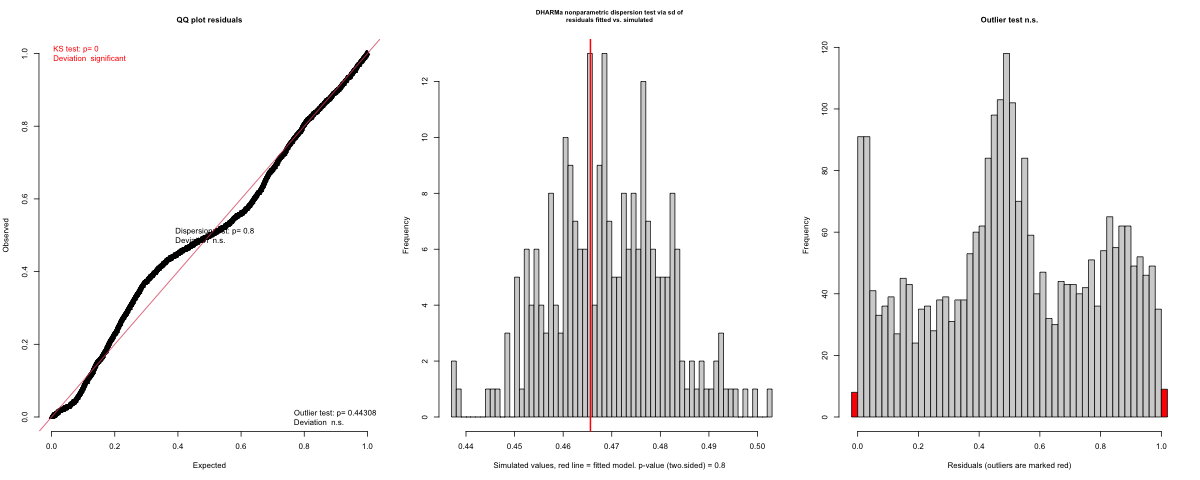

In [106]:
%%R -i compMedInc -w 1200 
library(mgcv)
library(dplyr)

library(DHARMa)

simulationOutput <- simulateResiduals(fittedModel = gam_model_log)
print(plot(simulationOutput))
testResiduals(simulationOutput)


In [107]:
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank,LOCPCT,STGPCT
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0,0.000000,0.931502
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0,0.101412,0.824866
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0,0.345770,0.549295
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5,0.000000,0.855271
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0,0.001777,0.931615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0,0.407490,0.536287
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0,0.259116,0.676913
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0,0.606854,0.305242
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0,0.333679,0.608120


In [108]:
personal_income.year = personal_income.year.astype(int)

In [109]:
pi_lib = personal_income.merge(compMedInc, left_on=['year', 'County'], right_on=['year', 'CNTY'])
pi_lib

,County,year,personal_income,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank,LOCPCT,STGPCT
0,ADAMS,1992,0.127775,ADAMS,445219,482333,0,25979.0,17.137650,0.000000,18.566265,1200.0,79.0,0.000000,0.923053
1,ALLEN,1992,0.851547,ALLEN,2406750,2642501,80992,109446.0,21.990297,0.740018,24.144336,1576.0,49.0,0.030650,0.910785
2,ASHLAND,1992,0.368489,ASHLAND,1015251,1126765,750,48111.0,21.102264,0.015589,23.420112,1605.0,47.0,0.000666,0.901032
3,ASHTABULA,1992,0.614261,ASHTABULA,1866733,2442251,19858,100405.0,18.592032,0.197779,24.323998,1667.0,42.0,0.008131,0.764349
4,ATHENS,1992,0.374086,ATHENS,1028936,1124419,0,60354.0,17.048348,0.000000,18.630397,1919.0,30.0,0.000000,0.915082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,WASHINGTON,2021,0.395329,WASHINGTON,2400841,2945684,446379,61382.0,39.113111,7.272148,47.989378,1417.0,58.0,0.151537,0.815037
2636,WAYNE,2021,0.829057,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0,0.407490,0.536287
2637,WILLIAMS,2021,0.195575,WILLIAMS,1484399,3282578,1225699,37102.0,40.008598,33.035928,88.474422,1457.0,56.0,0.373395,0.452205
2638,WOOD,2021,1.053471,WOOD,4950042,9215103,3571464,126163.0,39.235291,28.308331,73.041248,2663.0,18.0,0.387566,0.537166



Family: gaussian 
Link function: identity 

Formula:
LOCPCT ~ s(personalIncome_log) + s(PROPERTY_TAX) + s(year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.149619   0.002177   68.74   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df      F p-value    
s(personalIncome_log) 8.590  8.948  40.77  <2e-16 ***
s(PROPERTY_TAX)       8.775  8.983  26.84  <2e-16 ***
s(year)               8.365  8.888 235.90  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.587   Deviance explained = 59.1%
GCV = 0.012635  Scale est. = 0.012507  n = 2640


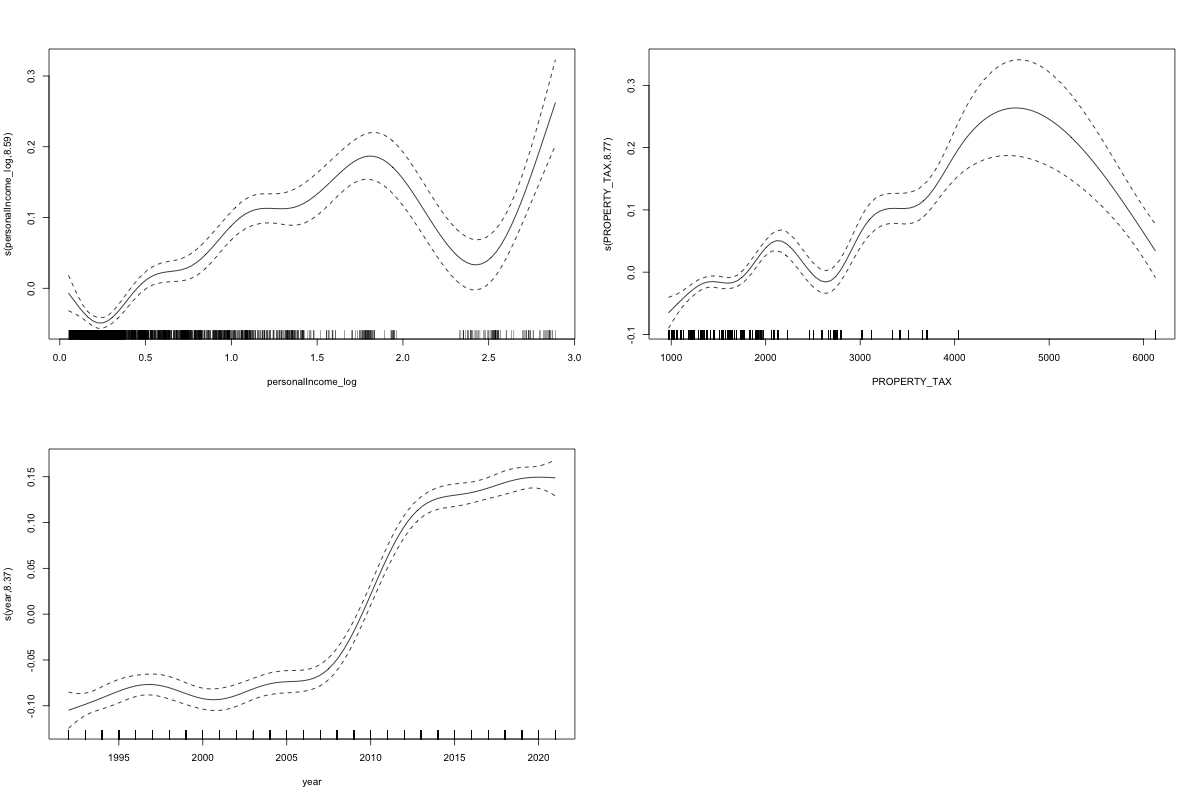

In [121]:
%%R -i pi_lib -h 800 -w 1200
library(mgcv)
library(dplyr)

pi_lib$PROPERTY_TAX_log <- log(pi_lib$PROPERTY_TAX + 1)
pi_lib$personalIncome_log <- log(pi_lib$personal_income + 1)
gam_model_log <- gam(LOCPCT ~  s(personalIncome_log) + s(PROPERTY_TAX) + s(year) , data = pi_lib)

# gam_model <- gam(LOCGVT_PER_CAPITA ~ s(PROPERTY_TAX) + s(year) + s(STRATIO), data = compMedInc)

print(summary(gam_model_log))


par(mfrow=c(3, 3)) 
plot(gam_model_log, pages=1, all.terms=TRUE, se=TRUE, scale=0)

par(mfrow=c(1,1))


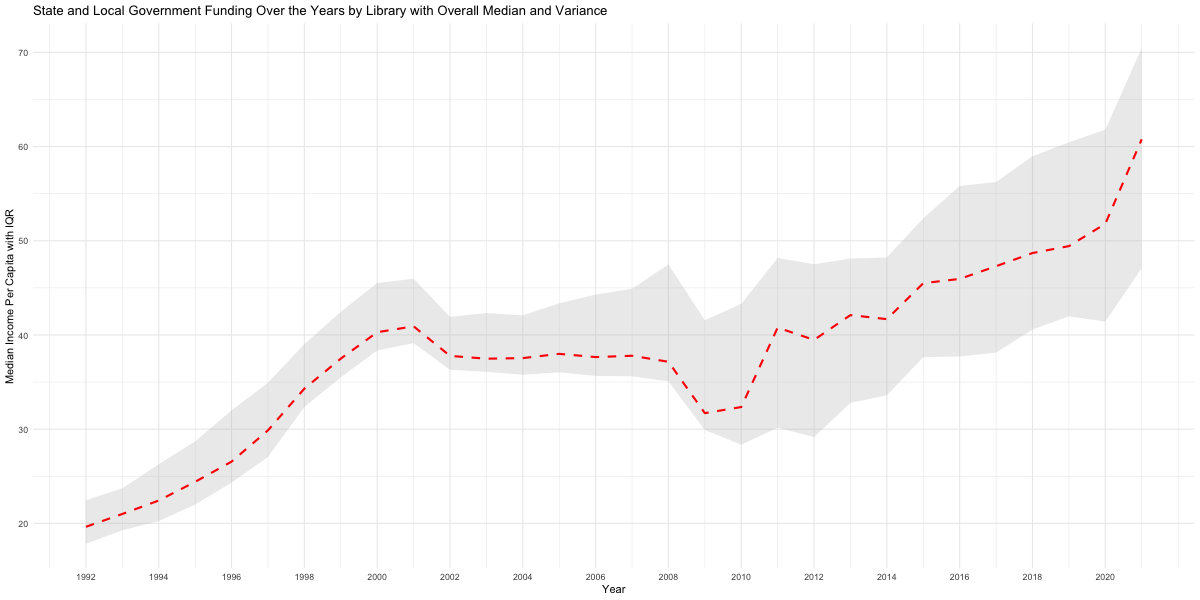

In [111]:
%%R -i compMedInc -w 1200 -h 600

library(ggplot2)
library(dplyr)

# Calculate median total income per year across all libraries
median_income_overall <- compMedInc %>%
  group_by(year) %>%
  summarise(total_income_overall = median((STGVT + LOCGVT )/POPU_LSA, na.rm = TRUE))

# Calculate median total income per year for each library
median_income_by_lib <- compMedInc %>%
  group_by(year, rank) %>%
  summarise(total_income_lib = median((STGVT + LOCGVT )/POPU_LSA, na.rm = TRUE), .groups = 'drop')

# Merge the overall median data with the per-library median data
combined_data <- left_join(median_income_by_lib, median_income_overall, by = "year")

# Calculate IQR or standard deviation for each year
spread_data <- compMedInc %>%
  group_by(year) %>%
  summarise(
    lower_bound = quantile((STGVT + LOCGVT)/POPU_LSA, 0.25, na.rm = TRUE),
    upper_bound = quantile((STGVT + LOCGVT)/POPU_LSA, 0.75, na.rm = TRUE)
  )

# Merge spread data with overall median data for plotting
combined_data_with_spread <- left_join(median_income_overall, spread_data, by = "year")

# Plot
ggplot() +
  geom_ribbon(data = combined_data_with_spread, aes(x = year, ymin = lower_bound, ymax = upper_bound), fill = "grey", alpha = 0.3) +
  geom_line(data = median_income_overall, aes(x = year, y = total_income_overall), color = "red", size = 1, linetype = "dashed") +
  scale_x_continuous(breaks = seq(min(combined_data_with_spread$year), max(combined_data_with_spread$year), by = 2)) +
  labs(title = 'State and Local Government Funding Over the Years by Library with Overall Median and Variance',
       x = 'Year',
       y = 'Median Income Per Capita with IQR') +
  theme_minimal() 
# ggsave("data/median_income_over_time.svg", width = 12, height = 8, units = "in", dpi = 300)